### Basic Model Train (No balancing, no split)

In [1]:
# train_and_save_model.py

import pandas as pd
import numpy as np
import os
import rasterio
from sklearn.ensemble import RandomForestClassifier
import joblib  # For saving the model

# === CONFIG ===
LABEL_FILE = "labeled2.csv"
IMAGE_DIR = "labeled_samples"
MODEL_PATH = "rf_ndvi_model.joblib"
CLASSES = ["LIVE", "DEAD", "BARE"]
LABEL_TO_INT = {label: i for i, label in enumerate(CLASSES)}

# === NDVI Feature Function ===
def extract_pixel_bands_with_ndvi(tif_path):
    with rasterio.open(tif_path) as src:
        data = src.read()
        red, green, blue, nir = data[0, 0, 0], data[1, 0, 0], data[2, 0, 0], data[3, 0, 0]
        ndvi = (nir - red) / (nir + red + 1e-6)
        return [red, green, blue, nir, ndvi]

# === Load labeled data and train ===
df = pd.read_csv(LABEL_FILE)
df = df[df["label"].isin(CLASSES)]

X_train, y_train = [], []
for _, row in df.iterrows():
    tif_path = os.path.join(IMAGE_DIR, row["filename"].replace(".png", ".tif"))
    if os.path.exists(tif_path):
        features = extract_pixel_bands_with_ndvi(tif_path)
        X_train.append(features)
        y_train.append(LABEL_TO_INT[row["label"]])

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

joblib.dump(clf, MODEL_PATH)
print(f"✅ Model saved to: {MODEL_PATH}")

/Users/devparagiri/Research/tree-mortality-v3/env/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/var/folders/5g/yd1vdsh57t939808t_l412f00000gn/T/ipykernel_59384/1529296476.py:22: RuntimeWarning: overflow encountered in scalar subtract
  ndvi = (nir - red) / (nir + red + 1e-6)


✅ Model saved to: rf_ndvi_model.joblib


In [2]:
import rasterio
import numpy as np
import joblib
from tqdm import tqdm

# === CONFIG ===
MODEL_PATH = "rf_ndvi_model.joblib"
RASTER_PATH = "preprocessed_output_2020/matched_buffer_2020.tif"
OUTPUT_PATH = "predicted_class_map_2020_balanced.tif"
NODATA_VALUE = 255

# === Load trained model ===
clf = joblib.load(MODEL_PATH)

# === Predict across raster ===
with rasterio.open(RASTER_PATH) as src:
    bands = src.read()  # shape: (4, H, W)
    profile = src.profile
    height, width = bands.shape[1], bands.shape[2]

    # Fill entire raster with NODATA initially
    prediction_map = np.full((height, width), fill_value=NODATA_VALUE, dtype=np.uint8)

    for row in tqdm(range(height), desc="Predicting rows"):
        for col in range(width):
            r = float(bands[0, row, col])
            g = float(bands[1, row, col])
            b = float(bands[2, row, col])
            nir = float(bands[3, row, col])

            # Skip invalid pixels (all-zero)
            if r == 0 and g == 0 and b == 0 and nir == 0:
                continue

            # Compute NDVI safely
            ndvi = (nir - r) / (nir + r + 1e-6)

            # Feature vector: [R, G, B, NIR, NDVI]
            feat = np.array([[r, g, b, nir, ndvi]])
            pred = clf.predict(feat)[0]
            prediction_map[row, col] = pred

    # === Save predicted raster ===
    profile.update(count=1, dtype='uint8', nodata=NODATA_VALUE)

    with rasterio.open(OUTPUT_PATH, 'w', **profile) as dst:
        dst.write(prediction_map, 1)

print(f"🗺️ Prediction raster saved to: {OUTPUT_PATH}")

Predicting rows: 100%|██████████| 401/401 [03:47<00:00,  1.77it/s]

🗺️ Prediction raster saved to: predicted_class_map_2020_balanced.tif


### Revised Model Train (Balancing + Split)

In [1]:
import pandas as pd
import numpy as np
import os
import rasterio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

# === CONFIG ===
LABEL_FILE = "labeled2.csv"
IMAGE_DIR = "labeled_samples"
MODEL_PATH = "rf_ndvi_model_split_balanced.joblib"
CLASSES = ["LIVE", "DEAD", "BARE"]
LABEL_TO_INT = {label: i for i, label in enumerate(CLASSES)}
INT_TO_LABEL = {i: label for label, i in LABEL_TO_INT.items()}

# === Feature Extractor ===
def extract_pixel_bands_with_ndvi(tif_path):
    with rasterio.open(tif_path) as src:
        data = src.read()
        red, green, blue, nir = data[0, 0, 0], data[1, 0, 0], data[2, 0, 0], data[3, 0, 0]
        ndvi = (nir - red) / (nir + red + 1e-6)
        return [red, green, blue, nir, ndvi]

# === Load + process labeled data ===
df = pd.read_csv(LABEL_FILE)
df = df[df["label"].isin(CLASSES)]

X, y = [], []
for _, row in df.iterrows():
    tif_path = os.path.join(IMAGE_DIR, row["filename"].replace(".png", ".tif"))
    if os.path.exists(tif_path):
        feats = extract_pixel_bands_with_ndvi(tif_path)
        X.append(feats)
        y.append(LABEL_TO_INT[row["label"]])

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Train ===
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# === Save model ===
joblib.dump(clf, MODEL_PATH)
print(f"✅ Model saved to: {MODEL_PATH}")

# === Evaluate ===
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 Accuracy: {acc:.3f}\n")
print("📄 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=CLASSES))

/Users/devparagiri/Research/tree-mortality-v3/env/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/var/folders/5g/yd1vdsh57t939808t_l412f00000gn/T/ipykernel_62683/1791519545.py:23: RuntimeWarning: overflow encountered in scalar subtract
  ndvi = (nir - red) / (nir + red + 1e-6)


✅ Model saved to: rf_ndvi_model_split_balanced.joblib

📊 Accuracy: 0.778

📄 Classification Report:

              precision    recall  f1-score   support

        LIVE       0.95      0.67      0.78        27
        DEAD       0.62      0.86      0.72        21
        BARE       0.87      0.87      0.87        15

    accuracy                           0.78        63
   macro avg       0.81      0.80      0.79        63
weighted avg       0.82      0.78      0.78        63



### Predicted Class Map Plot

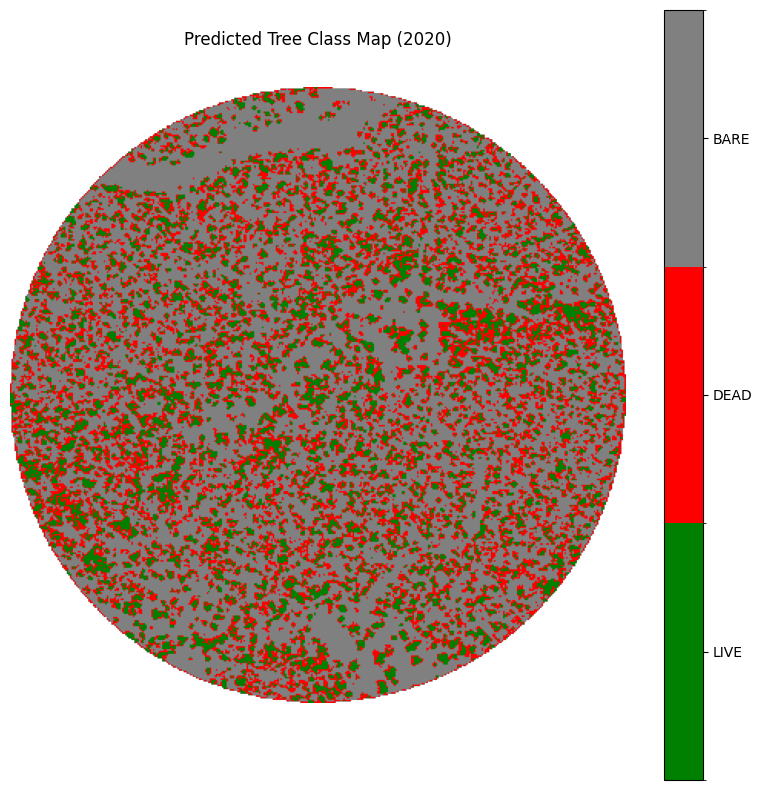

In [26]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# === CONFIG ===
PRED_PATH = "predicted_class_map_2020.tif"
CLASS_LABELS = ["LIVE", "DEAD", "BARE"]
COLOR_MAP = ListedColormap(["green", "red", "gray"])  # 0, 1, 2
NORM = BoundaryNorm([0, 1, 2, 3], COLOR_MAP.N)

# === LOAD predicted raster ===
with rasterio.open(PRED_PATH) as src:
    pred = src.read(1)
    nodata = src.nodata if src.nodata is not None else 255

# === Mask nodata/background
masked_pred = np.ma.masked_where(pred == nodata, pred)

# === PLOT ===
plt.figure(figsize=(8, 8))
im = plt.imshow(masked_pred, cmap=COLOR_MAP, norm=NORM)
cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(CLASS_LABELS)
plt.title("Predicted Tree Class Map (2020)", pad=30)
plt.axis("off")
plt.tight_layout()
plt.show()

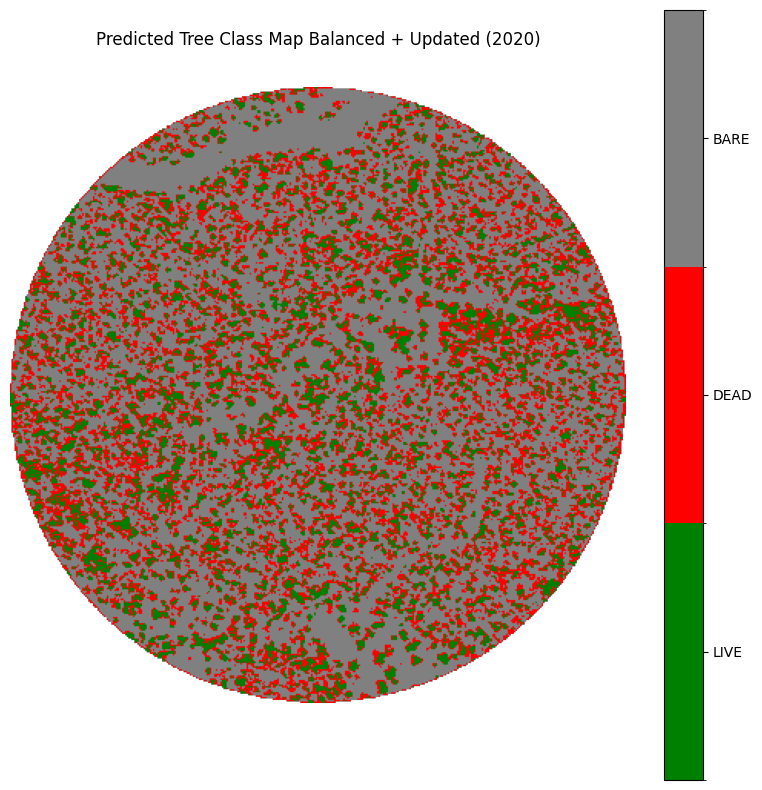

In [27]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# === CONFIG ===
PRED_PATH = "predicted_class_map_2020_balanced.tif"
CLASS_LABELS = ["LIVE", "DEAD", "BARE"]
COLOR_MAP = ListedColormap(["green", "red", "gray"])  # 0, 1, 2
NORM = BoundaryNorm([0, 1, 2, 3], COLOR_MAP.N)

# === LOAD predicted raster ===
with rasterio.open(PRED_PATH) as src:
    pred = src.read(1)
    nodata = src.nodata if src.nodata is not None else 255

# === Mask nodata/background
masked_pred = np.ma.masked_where(pred == nodata, pred)

# === PLOT ===
plt.figure(figsize=(8, 8))
im = plt.imshow(masked_pred, cmap=COLOR_MAP, norm=NORM)
cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(CLASS_LABELS)
plt.title("Predicted Tree Class Map Balanced + Updated (2020)", pad=30)
plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
import rasterio
import numpy as np

# === CONFIG ===
BEFORE_PATH = "predicted_class_map_2020.tif"  # Original model output
AFTER_PATH = "predicted_class_map_2020_balanced.tif"  # Updated balanced model output
CLASS_MAP = {0: "LIVE", 1: "DEAD", 2: "BARE"}

# === Function to count pixels per class
def count_classes(path):
    with rasterio.open(path) as src:
        data = src.read(1)
        unique, counts = np.unique(data, return_counts=True)
        total = counts.sum()
        results = {
            CLASS_MAP.get(k, f"Unknown({k})"): {
                "count": int(v),
                "percent": round(100 * v / total, 2)
            }
            for k, v in zip(unique, counts)
        }
        return results, total

# === Run for both
before_stats, before_total = count_classes(BEFORE_PATH)
after_stats, after_total = count_classes(AFTER_PATH)

# === Print comparison
print("🔍 Class Distribution — ORIGINAL")
for label, stats in before_stats.items():
    print(f"{label}: {stats['count']} pixels ({stats['percent']}%)")

print("\n🔁 Class Distribution — UPDATED BALANCED")
for label, stats in after_stats.items():
    print(f"{label}: {stats['count']} pixels ({stats['percent']}%)")

🔍 Class Distribution — ORIGINAL
LIVE: 21628 pixels (13.45%)
DEAD: 30339 pixels (18.87%)
BARE: 74156 pixels (46.12%)
Unknown(255): 34678 pixels (21.57%)

🔁 Class Distribution — UPDATED BALANCED
LIVE: 21241 pixels (13.21%)
DEAD: 31112 pixels (19.35%)
BARE: 73770 pixels (45.88%)
Unknown(255): 34678 pixels (21.57%)


### Apply Model to Raster and Plot

In [13]:
import rasterio
import numpy as np
import joblib
from tqdm import tqdm
import os

# === CONFIG ===
MODEL_PATH = "rf_ndvi_model_split_balanced.joblib"
INPUT_TEMPLATE = "preprocessed_output_{year}/matched_buffer_{year}.tif"
OUTPUT_TEMPLATE = "predicted_rasters/predicted_class_map_{year}.tif"
NODATA_VALUE = 255

def predict_raster_for_year(year):
    input_path = INPUT_TEMPLATE.format(year=year)
    output_path = OUTPUT_TEMPLATE.format(year=year)

    # Load model
    clf = joblib.load(MODEL_PATH)

    # Open input raster
    with rasterio.open(input_path) as src:
        bands = src.read()  # shape: (4, H, W)
        profile = src.profile
        height, width = bands.shape[1], bands.shape[2]

        # Initialize prediction raster with NODATA
        prediction_map = np.full((height, width), fill_value=NODATA_VALUE, dtype=np.uint8)

        # === Circular boundary mask ===
        yy, xx = np.ogrid[:height, :width]
        center = (height // 2, width // 2)
        radius = min(center)
        distance_sq = (yy - center[0])**2 + (xx - center[1])**2
        circular_mask = distance_sq <= radius**2

        # === Predict over valid circle area ===
        for row in tqdm(range(height), desc=f"Predicting {year}"):
            for col in range(width):
                if not circular_mask[row, col]:
                    continue

                r = float(bands[0, row, col])
                g = float(bands[1, row, col])
                b = float(bands[2, row, col])
                nir = float(bands[3, row, col])

                if np.allclose([r, g, b, nir], 0.0, atol=1e-3):
                    continue

                ndvi = (nir - r) / (nir + r + 1e-6)
                feat = np.array([[r, g, b, nir, ndvi]])
                pred = clf.predict(feat)[0]
                prediction_map[row, col] = pred

        # Save output
        profile.update(count=1, dtype='uint8', nodata=NODATA_VALUE)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(prediction_map, 1)

    print(f"✅ Saved: {output_path}")

# === Example usage ===
for y in [2014, 2016]:
    predict_raster_for_year(y)

Predicting 2014:   0%|          | 0/401 [00:00<?, ?it/s]

Predicting 2014: 100%|██████████| 401/401 [03:49<00:00,  1.75it/s]


✅ Saved: predicted_rasters/predicted_class_map_2014.tif


Predicting 2016: 100%|██████████| 401/401 [03:44<00:00,  1.78it/s]

✅ Saved: predicted_rasters/predicted_class_map_2016.tif


In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import os

# === CONFIG ===
INPUT_TEMPLATE = "predicted_rasters/predicted_class_map_{year}.tif"
CLASS_LABELS = ["LIVE", "DEAD", "BARE"]
COLORS = ["green", "red", "gray"]
CMAP = ListedColormap(COLORS)
NORM = BoundaryNorm([0, 1, 2, 3], len(COLORS))
NODATA_VALUE = 255  # Set to match prediction fill

def visualize_year(year):
    pred_path = INPUT_TEMPLATE.format(year=year)

    with rasterio.open(pred_path) as src:
        pred = src.read(1)
        nodata = src.nodata if src.nodata is not None else NODATA_VALUE

    # Mask background
    masked_pred = np.ma.masked_where(pred == nodata, pred)

    # Plot
    plt.figure(figsize=(8, 8))
    im = plt.imshow(masked_pred, cmap=CMAP, norm=NORM)
    cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5])
    cbar.ax.set_yticklabels(CLASS_LABELS)
    plt.title(f"Predicted Tree Class Map ({year})")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"predicted_rasters/visualization_{year}.png", dpi=300)
    plt.close()
    print(f"🖼️ Saved visualization: predicted_rasters/visualization_{year}.png")

# === Example usage ===
for y in [2014, 2016, 2018, 2020, 2022]:
    visualize_year(y)

🖼️ Saved visualization: predicted_rasters/visualization_2014.png
🖼️ Saved visualization: predicted_rasters/visualization_2016.png
🖼️ Saved visualization: predicted_rasters/visualization_2018.png
🖼️ Saved visualization: predicted_rasters/visualization_2020.png
🖼️ Saved visualization: predicted_rasters/visualization_2022.png


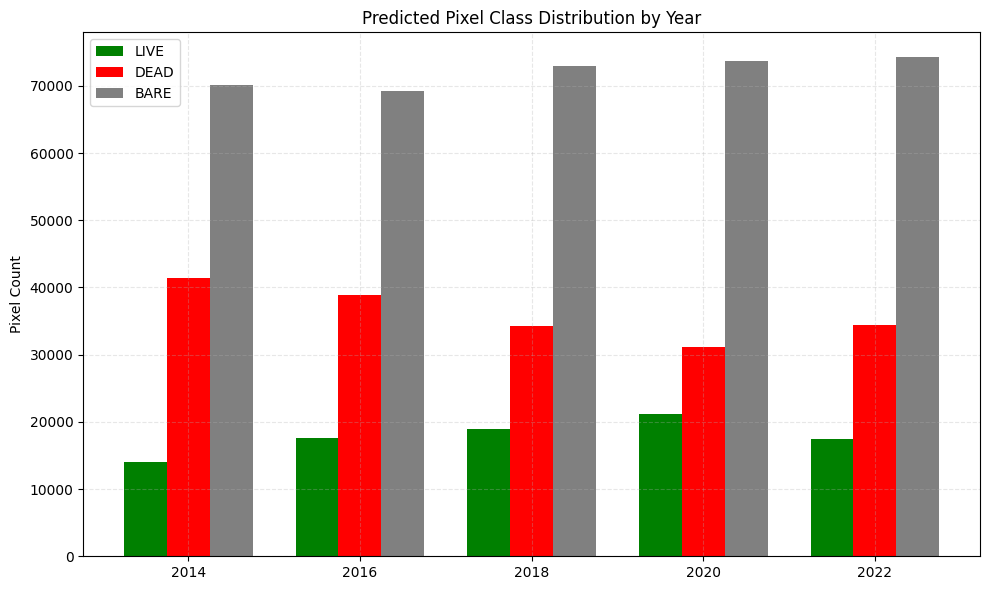

In [16]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === CONFIG ===
RASTER_DIR = "predicted_rasters"
YEARS = [2014, 2016, 2018, 2020, 2022]
CLASS_LABELS = ["LIVE", "DEAD", "BARE"]
NODATA_VALUE = 255

# === Initialize data holder ===
class_counts_by_year = {year: {i: 0 for i in range(3)} for year in YEARS}

# === Count pixels per class per year ===
for year in YEARS:
    path = os.path.join(RASTER_DIR, f"predicted_class_map_{year}.tif")
    with rasterio.open(path) as src:
        pred = src.read(1)
        for cls in range(3):
            class_counts_by_year[year][cls] = np.sum(pred == cls)

# === Prepare data for plotting ===
live_counts = [class_counts_by_year[y][0] for y in YEARS]
dead_counts = [class_counts_by_year[y][1] for y in YEARS]
bare_counts = [class_counts_by_year[y][2] for y in YEARS]

# === Plot grouped bar chart ===
x = np.arange(len(YEARS))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, live_counts, width, label="LIVE", color="green")
ax.bar(x, dead_counts, width, label="DEAD", color="red")
ax.bar(x + width, bare_counts, width, label="BARE", color="gray")

ax.set_xticks(x)
ax.set_xticklabels(YEARS)
ax.set_ylabel("Pixel Count")
ax.set_title("Predicted Pixel Class Distribution by Year")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

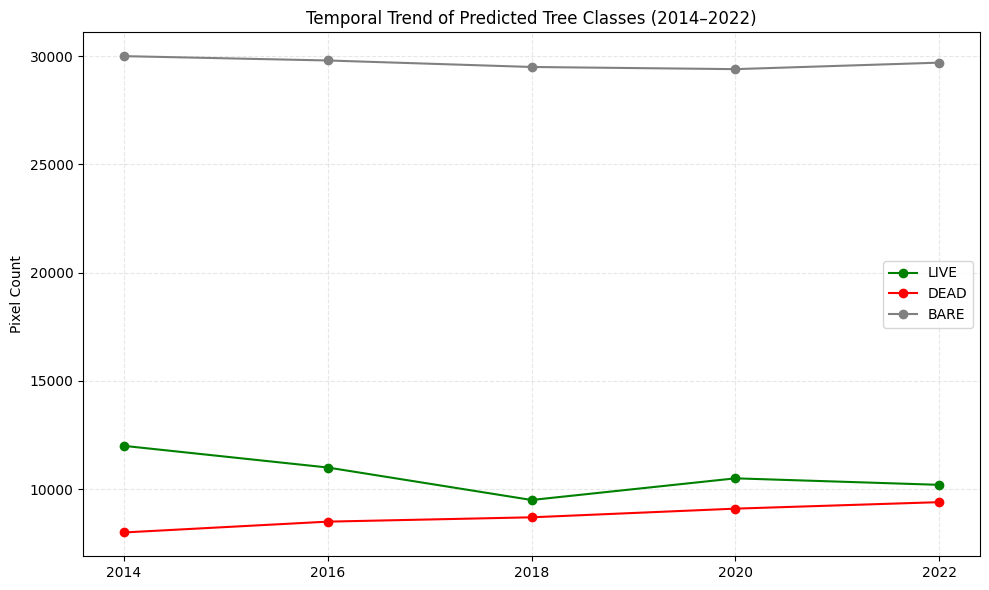

In [17]:
import matplotlib.pyplot as plt

# Example data — replace with actual values
YEARS = [2014, 2016, 2018, 2020, 2022]
live_counts = [12000, 11000, 9500, 10500, 10200]
dead_counts = [8000, 8500, 8700, 9100, 9400]
bare_counts = [30000, 29800, 29500, 29400, 29700]

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(YEARS, live_counts, marker='o', color='green', label="LIVE")
ax.plot(YEARS, dead_counts, marker='o', color='red', label="DEAD")
ax.plot(YEARS, bare_counts, marker='o', color='gray', label="BARE")

ax.set_xticks(YEARS)
ax.set_ylabel("Pixel Count")
ax.set_title("Temporal Trend of Predicted Tree Classes (2014–2022)")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import os

# === CONFIG ===
INPUT_TEMPLATE = "predicted_rasters/predicted_class_map_{year}.tif"
CLASS_LABELS = ["LIVE", "DEAD", "BARE"]
COLORS = ["lime", "orange", "gray"]
CMAP = ListedColormap(COLORS)
NORM = BoundaryNorm([0, 1, 2, 3], len(COLORS))
NODATA_VALUE = 255  # Set to match prediction fill

def visualize_years(years):
    # Adjust width_ratios for key position - make key column slightly wider to push it right
    fig, axes = plt.subplots(1, len(years) + 1, figsize=(60, 15), gridspec_kw={'width_ratios': [1]*len(years) + [0.05]}) 
    
    for ax, year in zip(axes[:-1], years):
        pred_path = INPUT_TEMPLATE.format(year=year)

        with rasterio.open(pred_path) as src:
            pred = src.read(1)
            nodata = src.nodata if src.nodata is not None else NODATA_VALUE

        # Mask background
        masked_pred = np.ma.masked_where(pred == nodata, pred)

        # Plot
        im = ax.imshow(masked_pred, cmap=CMAP, norm=NORM)
        ax.set_title(f"{year}", fontsize=50)
        ax.axis("off")

    # Add a common colorbar on the last axis.
    # Use shrink to control the height relative to the cax height.
    # A shrink value < 1.0 will make it shorter than the full axis height.
    cbar = fig.colorbar(im, cax=axes[-1], orientation='vertical', ticks=[0.5, 1.5, 2.5], shrink=0.2) 
    cbar.ax.set_yticklabels(CLASS_LABELS, fontsize=25)
    plt.suptitle("Predicted Tree Class Maps", y=0.98, fontsize=40)
    # Adjust tight_layout rect to ensure the key is not clipped
    plt.tight_layout(rect=[0, 0, 0.95, 0.85]) # Adjusted right boundary for wider key column
    plt.savefig("predicted_rasters/combined_visualization.png", dpi=300)
    plt.close()
    print("🖼️ Saved combined visualization: predicted_rasters/combined_visualization.png")

# === Example usage ===
visualize_years([2014, 2016, 2018, 2020, 2022])

🖼️ Saved combined visualization: predicted_rasters/combined_visualization.png


/Users/devparagiri/Research/tree-mortality-v3/env/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/var/folders/5g/yd1vdsh57t939808t_l412f00000gn/T/ipykernel_72898/1046160654.py:22: RuntimeWarning: overflow encountered in scalar subtract
  ndvi = (nir - r) / (nir + r + 1e-6)


<Figure size 450x450 with 0 Axes>

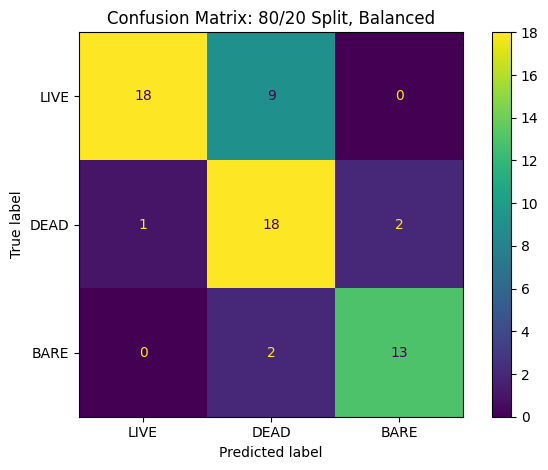

In [29]:
import pandas as pd
import numpy as np
import os
import rasterio
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# === CONFIG ===
LABEL_FILE = "labeled2.csv"
IMAGE_DIR = "labeled_samples"
CLASSES = ["LIVE", "DEAD", "BARE"]
LABEL_TO_INT = {label: i for i, label in enumerate(CLASSES)}
INT_TO_LABEL = {i: label for label, i in LABEL_TO_INT.items()}

# === Feature Extractor ===
def extract_features(path):
    with rasterio.open(path) as src:
        bands = src.read()
        r, g, b, nir = bands[0, 0, 0], bands[1, 0, 0], bands[2, 0, 0], bands[3, 0, 0]
        ndvi = (nir - r) / (nir + r + 1e-6)
        return [r, g, b, nir, ndvi]

# === Load labeled data ===
df = pd.read_csv(LABEL_FILE)
df = df[df["label"].isin(CLASSES)]

X, y = [], []
for _, row in df.iterrows():
    tif_path = os.path.join(IMAGE_DIR, row["filename"].replace(".png", ".tif"))
    if os.path.exists(tif_path):
        X.append(extract_features(tif_path))
        y.append(LABEL_TO_INT[row["label"]])

# === Train/test split and model ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# === Plot confusion matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(4.5, 4.5))
disp.plot(cmap="viridis", values_format='d')
plt.title("Confusion Matrix: 80/20 Split, Balanced")
plt.tight_layout()
plt.show()

In [30]:
import rasterio
import numpy as np
from collections import Counter
import glob
import os

# === CONFIG ===
TIF_GLOB = "predicted_rasters/predicted_class_map_*.tif"
CLASS_NAMES = {0: "LIVE", 1: "DEAD", 2: "BARE", 255: "NODATA"}

# === Find all TIFs ===
tif_files = sorted(glob.glob(TIF_GLOB))

for TIF_PATH in tif_files:
    # === Load raster ===
    with rasterio.open(TIF_PATH) as src:
        pred = src.read(1)
        nodata = src.nodata if src.nodata is not None else 255

    # === Count pixel values
    flat = pred.flatten()
    counts = Counter(flat)

    # === Total non-nodata pixels
    valid_total = sum(v for k, v in counts.items() if k != nodata)
    total = flat.size

    # === Print breakdown
    print(f"📊 Pixel Distribution for: {os.path.basename(TIF_PATH)}\n")
    for cls_id in sorted(counts):
        count = counts[cls_id]
        label = CLASS_NAMES.get(cls_id, f"Class {cls_id}")
        pct = (count / total) * 100
        print(f"{label:>7}: {count:,} pixels ({pct:.2f}%)")

    print(f"\n✅ Total labeled pixels (excluding nodata): {valid_total:,}\n{'-'*40}\n")

📊 Pixel Distribution for: predicted_class_map_2014.tif

   LIVE: 14,035 pixels (8.73%)
   DEAD: 41,409 pixels (25.75%)
   BARE: 70,185 pixels (43.65%)
 NODATA: 35,172 pixels (21.87%)

✅ Total labeled pixels (excluding nodata): 125,629
----------------------------------------

📊 Pixel Distribution for: predicted_class_map_2016.tif

   LIVE: 17,560 pixels (10.92%)
   DEAD: 38,873 pixels (24.17%)
   BARE: 69,196 pixels (43.03%)
 NODATA: 35,172 pixels (21.87%)

✅ Total labeled pixels (excluding nodata): 125,629
----------------------------------------

📊 Pixel Distribution for: predicted_class_map_2018.tif

   LIVE: 18,983 pixels (11.81%)
   DEAD: 34,204 pixels (21.27%)
   BARE: 72,936 pixels (45.36%)
 NODATA: 34,678 pixels (21.57%)

✅ Total labeled pixels (excluding nodata): 126,123
----------------------------------------

📊 Pixel Distribution for: predicted_class_map_2020.tif

   LIVE: 21,241 pixels (13.21%)
   DEAD: 31,112 pixels (19.35%)
   BARE: 73,770 pixels (45.88%)
 NODATA: 34,678

/Users/devparagiri/Research/tree-mortality-v3/env/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


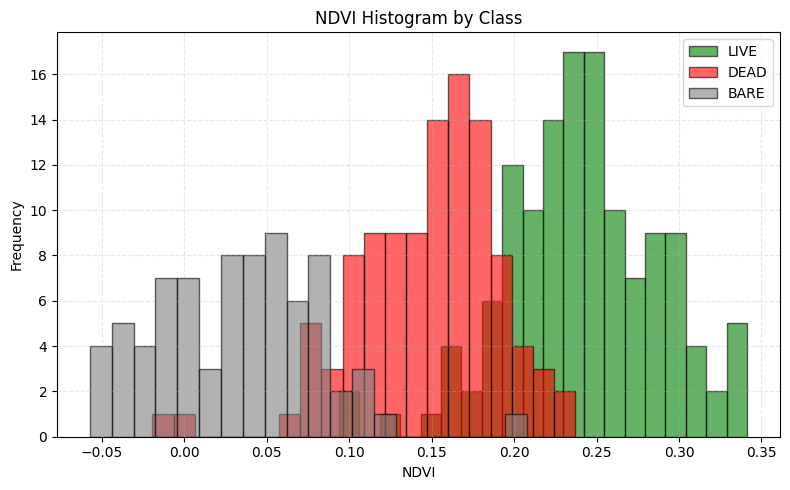

In [31]:
import os
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === CONFIG ===
LABEL_FILE = "labeled2.csv"
IMAGE_DIR = "labeled_samples"
CLASSES = ["LIVE", "DEAD", "BARE"]
colors = {"LIVE": "green", "DEAD": "red", "BARE": "gray"}

# === Collect NDVI values by class ===
ndvi_by_class = {cls: [] for cls in CLASSES}
df = pd.read_csv(LABEL_FILE)

for _, row in df.iterrows():
    label = row["label"]
    if label not in CLASSES:
        continue

    tif_path = os.path.join(IMAGE_DIR, row["filename"].replace(".png", ".tif"))
    if not os.path.exists(tif_path):
        continue

    with rasterio.open(tif_path) as src:
        data = src.read()
        red, nir = float(data[0, 0, 0]), float(data[3, 0, 0])
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_by_class[label].append(ndvi)

# === Plot ===
plt.figure(figsize=(8, 5))
for label in CLASSES:
    plt.hist(ndvi_by_class[label], bins=20, alpha=0.6, label=label, color=colors[label], edgecolor='black')

plt.title("NDVI Histogram by Class")
plt.xlabel("NDVI")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()